In [33]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from sklearn import metrics

In [34]:
training_df = pl.read_csv('data/training_smiles.csv')

## Feature engineering

In [35]:
features_dict = {
    "MolWeight": pl.Float64,
    "Fragments": pl.Int64,
    "Lipinski-HAcount": pl.Int64,
    "LogP": pl.Float64,
    "TPSA": pl.Float64,
    "HBD": pl.Int64,
    "HBA": pl.Int64,
}
base_features = list(features_dict.keys())

In [36]:
from rdkit.Chem import rdMolDescriptors as d
import rdkit.Chem.Fragments as f
from rdkit.Chem import Lipinski as l
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

#generator = GetMorganGenerator(radius=2, fpSize=64)

# Define a function to calculate all features
def calculate_all_features(smiles):

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None
    
    mol_weight = d.CalcExactMolWt(mol)
    #print(f"molwt {mol_weight}")
    fragments = f.fr_Al_COO(mol)
    #print(f"fragments {fragments}")
    lipinski = l.HeavyAtomCount(mol)
    #print(f"lipinski {lipinski}")
    logp, _ = d.CalcCrippenDescriptors(mol)
    #print(f"logp {logp}")
    tpsa = d.CalcTPSA(mol)
    #print(f"tpsa {tpsa}")
    hbd = d.CalcNumHBD(mol)
    #print(f"hbd {hbd}")
    hba = d.CalcNumHBA(mol)
    #print(f"hba {hba}")
    
    #fingerprint = np.array(generator.GetFingerprint(mol))
    #fingerprint = [int(bit) for bit in fingerprint]
    # print(fingerprint.sum())

    return mol_weight, fragments, lipinski, logp, tpsa, hbd, hba#, *fingerprint  # Unpack the fingerprint array

# First add base features with the working fix
training_df = training_df.with_columns([
    pl.col("SMILES").map_elements(
        lambda x, idx=i: calculate_all_features(x)[idx],  # Use idx parameter to capture the correct index
        return_dtype=features_dict[feature]
    ).alias(feature) 
    for i, feature in enumerate(base_features)
])

# Then, add the fingerprint columns with the same fix
#fingerprint_columns = [
#    pl.col("SMILES").map_elements(
#        lambda x, idx=i: calculate_all_features(x)[7 + idx],  # Offset by 7 to get to fingerprint values
#        return_dtype=pl.Int64
#    ).alias(f"Fingerprint_{i}") 
#    for i in range(1024)
#]

#training_df = training_df.with_columns(fingerprint_columns)

# Update features list to include fingerprint columns
features = list(features_dict.keys())# + [f"Fingerprint_{i}" for i in range(1024)]

[20:39:50] WARNING: not removing hydrogen atom without neighbors
[20:39:55] WARNING: not removing hydrogen atom without neighbors
[20:40:01] WARNING: not removing hydrogen atom without neighbors
[20:40:07] WARNING: not removing hydrogen atom without neighbors
[20:40:15] WARNING: not removing hydrogen atom without neighbors
[20:40:21] WARNING: not removing hydrogen atom without neighbors
[20:40:27] WARNING: not removing hydrogen atom without neighbors


In [37]:
training_df.select(features)

MolWeight,Fragments,Lipinski-HAcount,LogP,TPSA,HBD,HBA
f64,i64,i64,f64,f64,i64,i64
484.136155,0,31,5.9066,59.59,2,4
484.163436,0,36,6.2544,117.12,4,6
253.991676,0,16,2.25409,58.02,2,4
383.184506,0,28,3.1573,89.02,2,5
320.114791,0,22,2.2296,61.36,3,4
…,…,…,…,…,…,…
412.120526,0,29,3.15514,110.28,2,6
429.137636,0,32,4.49952,57.53,0,5
507.130091,0,34,2.5437,149.58,2,11


In [38]:
training_df.select(features).corr()

MolWeight,Fragments,Lipinski-HAcount,LogP,TPSA,HBD,HBA
f64,f64,f64,f64,f64,f64,f64
1.0,0.166106,0.974827,0.132006,0.706968,0.475621,0.652237
0.166106,1.0,0.162417,-0.142986,0.302008,0.343979,0.091087
0.974827,0.162417,1.0,0.140557,0.701826,0.467967,0.645983
0.132006,-0.142986,0.140557,1.0,-0.407138,-0.324136,-0.278376
0.706968,0.302008,0.701826,-0.407138,1.0,0.736761,0.768703
0.475621,0.343979,0.467967,-0.324136,0.736761,1.0,0.332933
0.652237,0.091087,0.645983,-0.278376,0.768703,0.332933,1.0


In [39]:
# Optional: Save the training features df
#training_df.write_parquet("final_enriched_training_df.parquet")

## Make prediction

In [40]:
# training_df = pl.read_parquet("enriched_training_df.parquet")

In [41]:
from sklearn.model_selection import train_test_split

X = training_df[features]
y = training_df[['ACTIVE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [42]:
value_counts = training_df['ACTIVE'].value_counts()
print("Raw counts:")
print(value_counts)

# Actual ratio
ratio = (value_counts.filter(pl.col("ACTIVE") == 0.0)["count"] / value_counts.filter(pl.col("ACTIVE") == 1.0)["count"]).item()
print("\nCalculated ratio (negative/positive):")
print(ratio)

Raw counts:
shape: (2, 2)
┌────────┬────────┐
│ ACTIVE ┆ count  │
│ ---    ┆ ---    │
│ f64    ┆ u32    │
╞════════╪════════╡
│ 1.0    ┆ 7933   │
│ 0.0    ┆ 201005 │
└────────┴────────┘

Calculated ratio (negative/positive):
25.33782932055969


In [43]:
# Use GridSearchCV to find the best parameters for XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = {
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [5, 10, 20, 50, 100],
    # 'scale_pos_weight': [1, ratio],
    'objective': ['binary:logistic', 'binary:hinge', 'binary:logitraw']
}
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42, eval_metric='auc'), param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

In [44]:
from xgboost import XGBClassifier

best_params = {'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

# Taken from https://xgboost.readthedocs.io/en/stable/get_started.html
bst = XGBClassifier(
    **best_params,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='auc'
)

In [45]:
X_train, y_train

(shape: (167_150, 7)
 ┌────────────┬───────────┬──────────────────┬─────────┬───────┬─────┬─────┐
 │ MolWeight  ┆ Fragments ┆ Lipinski-HAcount ┆ LogP    ┆ TPSA  ┆ HBD ┆ HBA │
 │ ---        ┆ ---       ┆ ---              ┆ ---     ┆ ---   ┆ --- ┆ --- │
 │ f64        ┆ i64       ┆ i64              ┆ f64     ┆ f64   ┆ i64 ┆ i64 │
 ╞════════════╪═══════════╪══════════════════╪═════════╪═══════╪═════╪═════╡
 │ 444.243773 ┆ 0         ┆ 33               ┆ 5.03722 ┆ 58.87 ┆ 1   ┆ 6   │
 │ 457.247775 ┆ 0         ┆ 34               ┆ 3.95498 ┆ 81.81 ┆ 1   ┆ 6   │
 │ 344.09277  ┆ 0         ┆ 24               ┆ 3.4843  ┆ 58.64 ┆ 1   ┆ 3   │
 │ 394.330777 ┆ 0         ┆ 28               ┆ 2.0973  ┆ 64.68 ┆ 2   ┆ 4   │
 │ 401.177313 ┆ 0         ┆ 28               ┆ 2.72396 ┆ 79.37 ┆ 1   ┆ 4   │
 │ …          ┆ …         ┆ …                ┆ …       ┆ …     ┆ …   ┆ …   │
 │ 246.067428 ┆ 0         ┆ 16               ┆ -0.1208 ┆ 84.5  ┆ 2   ┆ 5   │
 │ 419.220892 ┆ 0         ┆ 31               ┆ 3.64672 

In [46]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [47]:
# GridSearchCV of Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

class_weights = {0.0: 1, 1.0: ratio}

params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
     'class_weight': [class_weights, 'balanced', None]
}
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:130

{'C': 0.1,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [ ]:
from sklearn.linear_model import LogisticRegression

class_weights = {0.0: 1, 1.0: ratio}

best_params = {'C': 0.1,
 # 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l1',
'solver': 'liblinear'}

clf = LogisticRegression(**best_params, random_state=42, class_weight=class_weights)

TypeError: sklearn.linear_model._logistic.LogisticRegression() got multiple values for keyword argument 'class_weight'

In [49]:
clf.fit(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=0.1, class_weight={0.0: 1, 1.0: 25.33782932055969},
                   penalty='l1', random_state=42, solver='liblinear')

## Evaluation

### Logistic Regression

In [50]:
clf_train_preds = clf.predict(X_train)

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, clf_train_preds)
auc = metrics.auc(fpr, tpr)
auc

0.6508626261842938

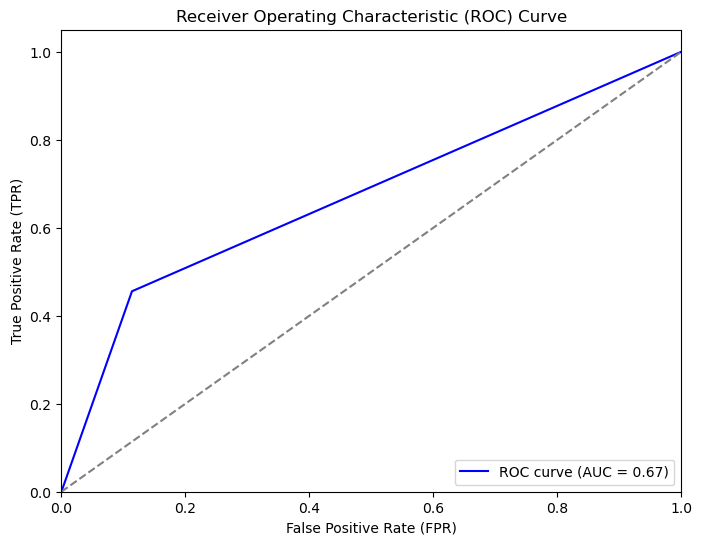

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('plots/auc_logistic.png')
plt.show()

In [53]:
val_preds = rf = clf.predict(X_test)

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, val_preds)
auc = metrics.auc(fpr, tpr)
auc

0.6529688786437943

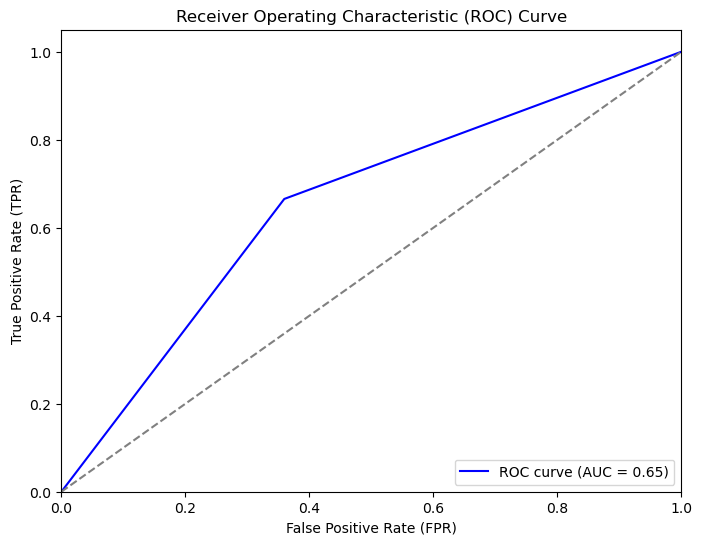

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [56]:
train_preds = bst.predict(X_train)

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_preds)
auc = metrics.auc(fpr, tpr)
auc

0.9292875178214345

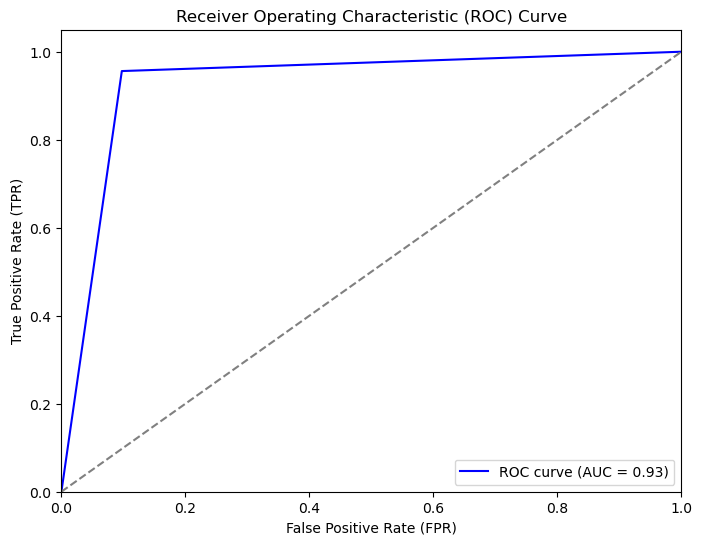

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [59]:
val_preds = bst.predict(X_test)

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, val_preds)
auc = metrics.auc(fpr, tpr)
auc

0.6708742726589061

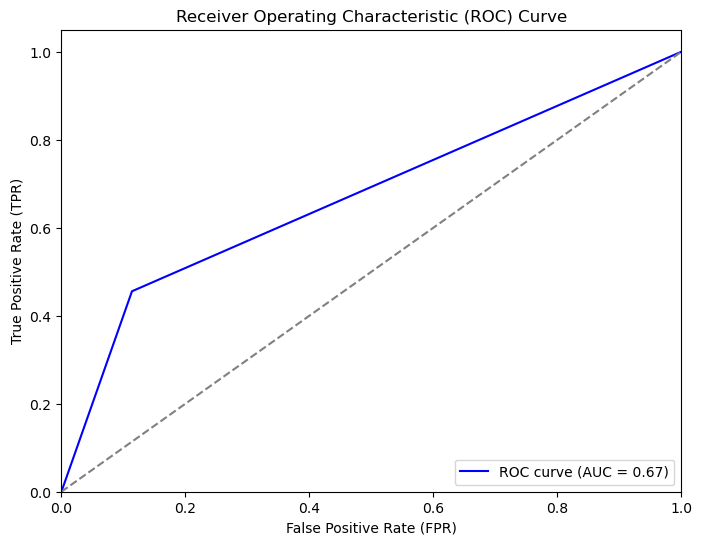

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('plots/auc_xgboost.png')
plt.show()

## Estimation + writing to file

In [62]:
test_df = pl.read_csv('data/test_smiles.csv')
test_df

INDEX,SMILES
i64,str
208939,"""CS(=O)(=O)Nc1ccc(C2=NN(S(C)(=O…"
208940,"""CCOC(=O)c1c(N)nn(C(=O)C(C)C)c1…"
208941,"""CCCc1cc(=O)oc2cc(C)cc(OCC(=O)N…"
208942,"""O=C1CC(C(=O)Nc2cc(Cl)ccc2Cl)N2…"
208943,"""COc1cccc(-c2nc(CS(=O)(=O)CC(=O…"
…,…
278580,"""O=C(CNC(=O)N1CC(=O)Nc2ccccc21)…"
278581,"""CCCOc1ccccc1Cn1c(=O)oc2ccc(C)c…"
278582,"""COc1ccc(C(=O)Nc2cc3c(oc2=O)CCC…"


In [63]:
test_df = test_df.with_columns([
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[0], return_dtype=pl.Float64).alias(features[0]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[1], return_dtype=pl.Int64).alias(features[1]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[2], return_dtype=pl.Int64).alias(features[2]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[3], return_dtype=pl.Float64).alias(features[3]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[4], return_dtype=pl.Float64).alias(features[4]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[5], return_dtype=pl.Int64).alias(features[5]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[6], return_dtype=pl.Int64).alias(features[6]),
    # pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[3], return_dtype=pl.String).alias("MorganFingerprints")
])

[22:00:00] WARNING: not removing hydrogen atom without neighbors
[22:00:02] WARNING: not removing hydrogen atom without neighbors
[22:00:04] WARNING: not removing hydrogen atom without neighbors
[22:00:06] WARNING: not removing hydrogen atom without neighbors
[22:00:08] WARNING: not removing hydrogen atom without neighbors
[22:00:10] WARNING: not removing hydrogen atom without neighbors
[22:00:12] WARNING: not removing hydrogen atom without neighbors


In [64]:
train_preds = bst.predict_proba(test_df[features])

We have excluded a part of the training set to be our validation set, and we thus expect the AUC in the test set to match it. Based on our best performing model - the XGBooster model, the value should be **0.5944**.

In [65]:
## Alternatively, we can look at the OOB performance - but it might benefit from overfitting, 
# due to it not being fully indepedent (in contrast to validation set performance).
best_params = {'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 50,
 'objective': 'binary:logistic'}

bst = XGBClassifier(
    **best_params,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='auc',
    # enable_categorical=True,  # Enable categorical features
    subsample=0.8,
)

bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
from sklearn.metrics import roc_auc_score
oob_predictions = bst.predict_proba(X_train)[:, 1]
oob_auc = roc_auc_score(y_train, oob_predictions)
print(f"Training OOB AUC-ROC: {oob_auc}")

Training OOB AUC-ROC: 0.9590218484764547


In [67]:
from sklearn.metrics import roc_auc_score
val_oob_predictions = bst.predict_proba(X_test)[:, 1]
val_oob_auc = roc_auc_score(y_test, val_oob_predictions)
print(f"Validation OOB AUC-ROC: {val_oob_auc}")

Validation OOB AUC-ROC: 0.7577071325599574


### Writing to file

In [68]:
with open("10.txt", "w") as f:
    f.write(f"{auc}\n")
    for pred in train_preds:
        positive_pred = pred[1]
        f.write(f"{positive_pred}\n")

In [69]:
predictions_df = pd.read_csv("10.txt", header=None)
assert predictions_df.shape == (69646+1, 1)
assert np.all((predictions_df.values >= 0) & (predictions_df.values <= 1))